In [1]:
# This notebook contains "basic" code samples related with DNN/CNN model training, adversarial sample crafting and adversarial training 
# in Pytorch using MNIST dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#download MNIST dataset
mnist_train = datasets.MNIST("/data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("/data", train=False, download=True, transform=transforms.ToTensor())

#prepare training and test set dataloaders

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [5]:
#helper class to reshape the 3-d image tensor to 2-d ([1,28,28] to [1,784])

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)


In [6]:
#define a simple 4-layer DNN model

model_dnn = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

In [7]:
#define a CNN model composed of 4 convolutional layers, followed by 2 linear(dense) layers

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [8]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [9]:
opt = optim.Adam(model_dnn.parameters(), lr=0.001)

#perform DNN training and output err/loss values for each epoch

for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn, opt)
    test_err, test_loss = epoch(test_loader, model_dnn)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")


0.107083	0.363785	0.045500	0.150601
0.038267	0.129683	0.035800	0.115835
0.026767	0.088603	0.026500	0.087992
0.020350	0.066188	0.026600	0.087486
0.015833	0.050551	0.027200	0.088398
0.013450	0.042206	0.024100	0.080622
0.010750	0.032836	0.021600	0.076364
0.008817	0.026440	0.030000	0.104555
0.007183	0.022987	0.024600	0.092461
0.006683	0.020772	0.023100	0.089344


In [10]:
opt = optim.Adam(model_cnn.parameters(), lr=0.001)

#perform CNN model training and output err/loss values for each epoch

for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.073000	0.232189	0.020500	0.066623
0.017867	0.059139	0.013900	0.044146
0.011900	0.037940	0.013200	0.038460
0.009067	0.028001	0.012100	0.037279
0.007133	0.022578	0.011200	0.037148
0.035217	0.121488	0.013300	0.049022
0.017033	0.057138	0.014800	0.049438
0.015183	0.049917	0.016700	0.050688
0.012933	0.043382	0.017300	0.057342
0.012467	0.042931	0.015300	0.055523


In [11]:
#save the trained models (optional)

torch.save(model_dnn.state_dict(), "model_dnn.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

In [12]:
#load the pretrained weights (optional)

model_dnn.load_state_dict(torch.load("model_dnn.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

In [13]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [14]:
def noise(x, eps, clip_min, clip_max):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    eta = torch.FloatTensor(*x.shape).normal_(mean=0,std=eps)
    eta = eta.to(device)
    adv_x = x + eta
    if clip_min is not None and clip_max is not None:
        adv_x = torch.clamp(adv_x, min=clip_min, max=clip_max)
    return adv_x

In [15]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

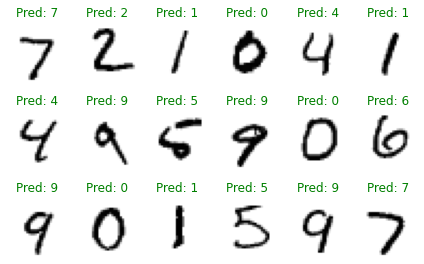

In [16]:
### Illustrate original predictions for dnn
# As can bee seen from below results, we have well performing model

yp = model_dnn(X)
plot_images(X, y, yp, 3, 6)

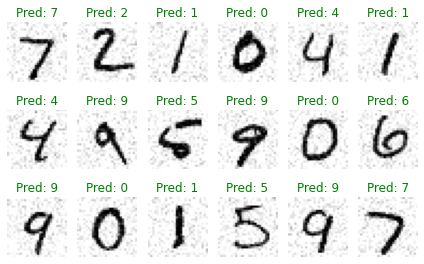

In [17]:
### Illustrate noisy samples for dnn
# As can be seen from below results, perturbations in the form of gauissian noise does not negatively affect model performance

noisy_X = noise(X, 0.1, 0, 1)
yp = model_dnn(noisy_X)
plot_images(noisy_X, y, yp, 3, 6)

In [18]:
# Now it is time to experiment on different attack methods

# We start with basic Untargeted attack methods

def fgsm(model, X, y, epsilon):
    """ Craft adversarial examples on the examples X via FGSM"""
    """ You first calculate the gradient of the loss w.r.t input"""
    """ then take the sign of the gradient and take one step in this direction """
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

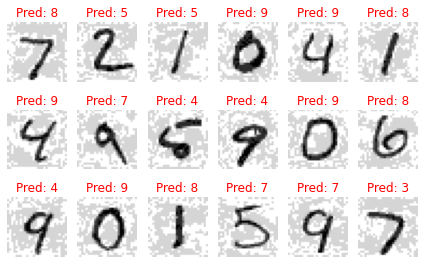

In [19]:
### Illustrate perturbed samples for dnn

delta = fgsm(model_dnn, X, y, 0.1)
yp = model_dnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

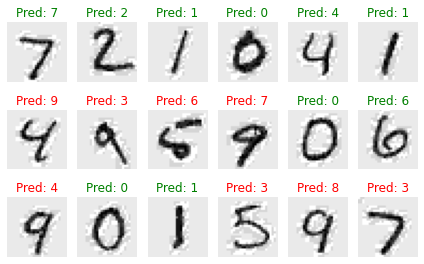

In [20]:
### Illustrate perturbed samples for cnn

delta = fgsm(model_cnn, X, y, 0.10)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

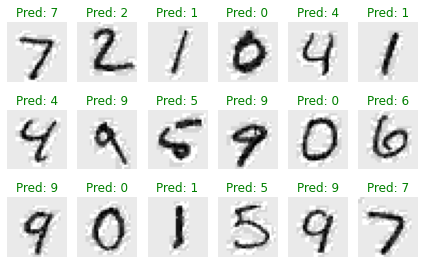

In [21]:
# Attack transferability (blackbox attack)

delta = fgsm(model_cnn, X, y, 0.10)
yp = model_dnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [22]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [23]:
# Evaluate the performance of the models (print error rates) on perturbed samples using all the test dataset, FGSM is used 

print("DNN:", epoch_adversarial(model_dnn, test_loader, fgsm, 0.1)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

DNN: 0.9417
CNN: 0.2966


In [24]:
# Untargeted attack

def bim(model, X, y, epsilon=0.1, alpha=0.02, num_iter=20):
    """ Craft adversarial examples on the examples X via BIM"""
    """ You take tiny gradient steps in the direction of the derivative of the loss function """
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

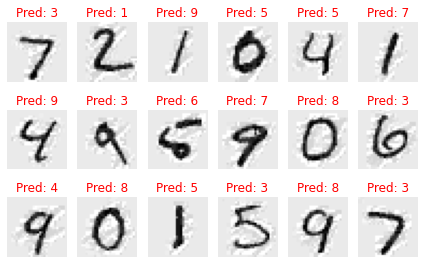

In [25]:
### Illustrate perturbed samples
delta = bim(model_cnn, X, y, epsilon=0.1, alpha=0.02, num_iter=20)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

# Note: 
# It is a whitebox attack. But if you use model_dnn in bim method, then its kind of blackbox attack. Since you craft 
# perturbations one one model and apply it on another , using the concept of attack transferability among ML models.

In [26]:
# Evaluate the performance of the models (print error rates) on perturbed samples using all the test dataset, BIM is used 

print("DNN:", epoch_adversarial(model_dnn, test_loader, bim, 0.1, 0.02, 20)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, bim, 0.1, 0.02, 20)[0])

DNN: 0.9982
CNN: 0.9343


In [27]:
# Untargeted attack

def pgd(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Craft adversarial examples on the examples X via PGD"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

In [28]:
# Evaluate the performance of the models (print error rates) on perturbed samples using all the test dataset, PGD is used 

print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd, 0.1, 0.02, 20, 5)[0])

CNN: 0.9911


In [29]:
#Now, it is the time for targeted attacks

In [30]:
def bim_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Craft targeted adversarial examples on the examples X via BIM_T"""
    """ You minimize the loss w.r.t target class and maximize the loss w.r.t original class"""
    """ Or, you just minimize the loss w.r.t target class"""
    target = (y_targ*torch.ones(y.shape[0])).view_as(y).to(torch.long)
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        #loss = nn.CrossEntropyLoss()(model(X + delta), y) - nn.CrossEntropyLoss()(model(X + delta), target)
        loss =  - nn.CrossEntropyLoss()(model(X + delta), target)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

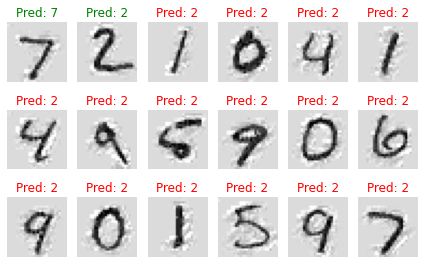

In [31]:
# try to fool the model in such a way that it always predict "2"
delta = bim_targ(model_cnn, X, y, epsilon=0.2, alpha=0.01, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

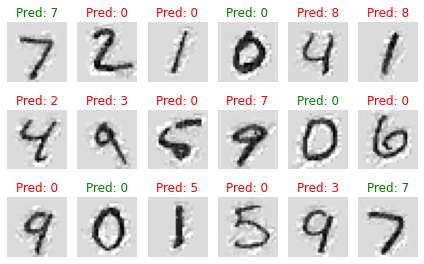

In [32]:
# try to fool the model in such a way that it always predict "0"
delta = bim_targ(model_cnn, X, y, epsilon=0.2, alpha=0.01, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [33]:
#ADVERSARIAL TRAINING PART

In [34]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [35]:
# Train the model using perturbed samples

def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [36]:
opt = optim.Adam(model_cnn_robust.parameters(), lr=0.001)

#perform adversarial training

for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, bim, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, bim)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

0.200983	0.022500	0.064000
0.057683	0.017000	0.048000
0.043283	0.013800	0.040100
0.034383	0.013300	0.035700
0.030000	0.012300	0.034300
0.142483	0.025400	0.072300
0.053817	0.019000	0.048000
0.049233	0.028400	0.077600
0.040917	0.015900	0.035800
0.110867	0.020000	0.079900


In [37]:
model_cnn_robust.load_state_dict(torch.load("model_cnn_robust.pt"))

<All keys matched successfully>

In [38]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm, epsilon = 0.1)[0])

FGSM:  0.0587


In [39]:
print("BIM, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, bim, num_iter=40)[0])

BIM, 40 iter:  0.0819


In [40]:
### UAP Part ###

In [41]:
#Here the attacker samples a set of data from his/her test set distribution.

test_loader2 = DataLoader(mnist_test, batch_size = 1000, shuffle=False)

for X_t,y_t in test_loader2:
    X_t,y_t = X_t.to(device), y_t.to(device)
    
    inds = np.where(y_t.cpu() == 9)[0]

    X_t = X_t[inds]
    y_t = y_t[inds]
    
    break

#And then attacker applies a known attack algorithm (like BIM) to craft perturbation vectors specific to each of these vectors. 

delta_t = bim(model_cnn, X_t, y_t, epsilon=0.2, alpha=0.01, num_iter=40)

#Then attacker combine all these perturbation vectors in a matrix and apply PCA algorithm. 
#Essentially, you find the eigenvector which corresponds to the largest eigenvalue in the covariance of the matrix. 
#This will probably work for many different inputs

U_svd, S_svd, Vh_svd = torch.linalg.svd(delta_t)

# As -Vh_svd[ 0:1,:] is also a valid right singular vector corresponding to the same singular value, 
# We check which one to choose by evaluating the corresponding sum of loss values.

loss2 = nn.CrossEntropyLoss(reduce=False)(model_cnn(X_t + (Vh_svd[ 0:1,:].detach().sign().clamp(-0.2, 0.2))), y_t.long()).sum().item()
print("loss2 ", loss2)

loss3 = nn.CrossEntropyLoss(reduce=False)(model_cnn(X_t - (Vh_svd[ 0:1,:].detach().sign().clamp(-0.2, 0.2))), y_t.long()).sum().item()
print("loss3 ", loss3)

if loss3>loss2:
    Vh_svd[ 0:1,:] = Vh_svd[ 0:1,:] * -1

loss2  74.69790649414062
loss3  128.4482421875


C:\Users\etunome\Anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [42]:
uap_pert = Vh_svd[ 0:1,:].detach().sign().clamp(-0.2, 0.2)

In [43]:
test_loader = DataLoader(mnist_test, batch_size = 1000, shuffle=False)

i = 0

for X,y in test_loader:
    
    X,y = X.to(device), y.to(device)
    
    inds = np.where(y.cpu() == 9)[0]

    X = X[inds]
    y = y[inds]
    
    i = i + 1
    
    if i == 2:
        break


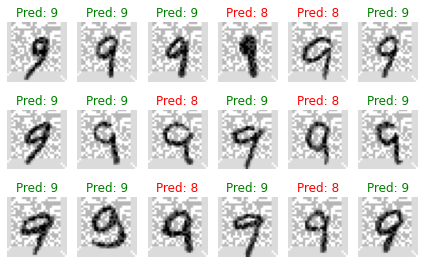

In [44]:
#yp = model_cnn(X + noise(X, 0.2, 0, 1))
#plot_images(X + noise(X, 0.2, 0, 1), y, yp, 3, 6) # Random noise does not affect

#yp = model_cnn_robust(X + uap_pert) # Robust model is not effected
yp = model_cnn(X + uap_pert)
plot_images(X + uap_pert, y, yp, 3, 6)

In [45]:
#for other attacks , you can use publicly available attack libraries

#import foolbox as fb
#from foolbox import PyTorchModel, accuracy, samples
#from foolbox.attacks import LinfPGD,LinfBasicIterativeAttack,LinfFastGradientAttack,L2CarliniWagnerAttack,LinfDeepFoolAttack,L2DeepFoolAttack
     
#attack = LinfDeepFoolAttack()
#fmodel = PyTorchModel(model_cnn, bounds=(0, 1))
#raw_advs, clipped_advs, success = attack(fmodel, image, label, epsilons=[eps])
#perturbed_sample = torch.tensor(clipped_advs[0])

#attack = L2DeepFoolAttack()
#fmodel = PyTorchModel(model_cnn, bounds=(0, 1))
#raw_advs, clipped_advs, success = attack(fmodel, image, label, epsilons=[eps_l2])
#perturbed_sample = torch.tensor(clipped_advs[0])

#attack = L2CarliniWagnerAttack(steps=1000, confidence = 0)
#fmodel = PyTorchModel(model_cnn, bounds=(0, 1))
#raw_advs, clipped_advs, success = attack(fmodel, image, label, epsilons=[eps_l2])
#perturbed_sample = torch.tensor(clipped_advs[0])